<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Main_Quest_2/%EC%9E%84%EC%A7%80%ED%98%9C_Chest_X_Ray_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#문제1. 이미지분류 모델 만들기

In [57]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230622")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230622'

In [27]:
#라이브러리 준비
import os, shutil, pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import image_dataset_from_directory

캐글-Chest X-Ray Images(폐렴)
- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [ ]:
#데이터 압축풀기
!unzip -qq archive.zip

데이터 전처리

In [ ]:
data_dir = pathlib.Path('chest_xray/chest_xray')

#directory에서 클래스별 이미지파일 인덱싱, 전처리, 배치로 묶기
train_dataset = image_dataset_from_directory(
    data_dir / 'train',
    image_size=(180, 180),   #shape=(224,224,3)
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_dir / 'val',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


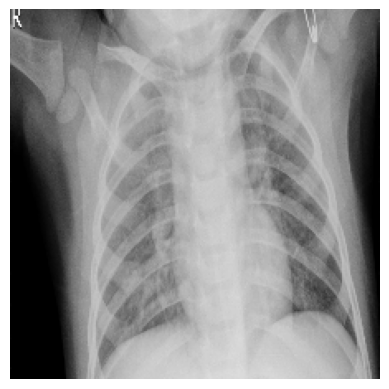

In [ ]:
#이미지 확인: 첫 번째 배치의 이미지와 레이블을 가져오기
images, _ = next(iter(train_dataset))

plt.imshow(images[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

In [ ]:
#Dataset이 반환하는 데이터와 레이블 크기 확인하기
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


폐렴여부를 분류하는 컨브넷 만들기
- 1차: 소규모 컨브넷 - 기본적인 머신모델 시도 -> 기준모델(테스트 정확도: 0.780)

In [ ]:
#케창딥 기준 input shape = (180, 180)
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
#모델 훈련 설정하기
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#모델훈련
log_dir = './logs'
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.TensorBoard(
        log_dir = "full_path_to_your_log_dir",
        histogram_freq = 1,
        write_graph = True, write_images = True
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
163/163 [==============================] - 1423s 9s/step - loss: 0.5506 - accuracy: 0.7561 - val_loss: 0.5705 - val_accuracy: 0.8125
Epoch 2/30
163/163 [==============================] - 41s 240ms/step - loss: 0.2535 - accuracy: 0.9155 - val_loss: 0.5025 - val_accuracy: 0.8125
Epoch 3/30
163/163 [==============================] - 40s 227ms/step - loss: 0.1327 - accuracy: 0.9549 - val_loss: 0.5285 - val_accuracy: 0.7500
Epoch 4/30
163/163 [==============================] - 39s 230ms/step - loss: 0.1155 - accuracy: 0.9569 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 5/30
163/163 [==============================] - 36s 212ms/step - loss: 0.0906 - accuracy: 0.9691 - val_loss: 0.0820 - val_accuracy: 1.0000
Epoch 6/30
163/163 [==============================] - 41s 239ms/step - loss: 0.0799 - accuracy: 0.9714 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 7/30
163/163 [==============================] - 36s 211ms/step - loss: 0.0627 - accuracy: 0.9726 - val_loss: 0.0291 - val_acc

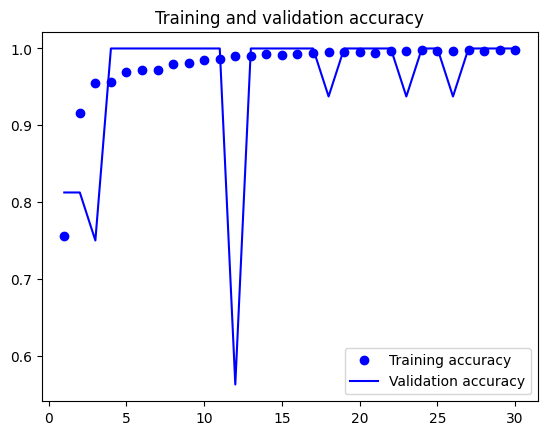

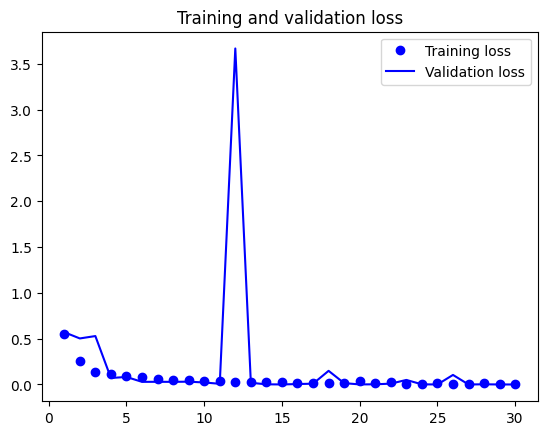

In [ ]:
#훈련 정확도와 손실 그래프 그리기

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

20/20 [==============================] - 224s 6s/step - loss: 4.9782 - accuracy: 0.7804
테스트 정확도: 0.780


- 2차: 소규모 컨브넷 - input_size 변경
>-> 테스트 결과 큰 차이 없음(테스트 정확도: 0.796) -> 3차: 모델 크기 키우기


In [ ]:
data_dir = pathlib.Path('chest_xray/chest_xray')

train_dataset = image_dataset_from_directory(
    data_dir / 'train',
    image_size=(224, 224),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_dir / 'val',
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_dir / 'test',
    image_size=(224, 224),
    batch_size=32)

#Dataset이 반환하는 데이터와 레이블 크기 확인하기
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
데이터 배치 크기: (32, 224, 224, 3)
레이블 배치 크기: (32,)


In [ ]:
#모델선언
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#모델 훈련 설정하기
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#모델훈련
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_1256.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.TensorBoard(
        log_dir = "full_path_to_your_log_dir_1256",
        histogram_freq = 1,
        write_graph = True, write_images = True)
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
163/163 [==============================] - 45s 255ms/step - loss: 0.0525 - accuracy: 0.9814 - val_loss: 0.1445 - val_accuracy: 0.9375
Epoch 2/30
163/163 [==============================] - 40s 239ms/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 1.5263 - val_accuracy: 0.6250
Epoch 3/30
163/163 [==============================] - 41s 240ms/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.2975 - val_accuracy: 0.8125
Epoch 4/30
163/163 [==============================] - 43s 254ms/step - loss: 0.0245 - accuracy: 0.9895 - val_loss: 1.3890 - val_accuracy: 0.8125
Epoch 5/30
163/163 [==============================] - 41s 245ms/step - loss: 0.0210 - accuracy: 0.9923 - val_loss: 0.2746 - val_accuracy: 0.9375
Epoch 6/30
163/163 [==============================] - 40s 230ms/step - loss: 0.0298 - accuracy: 0.9916 - val_loss: 0.1228 - val_accuracy: 0.9375
Epoch 7/30
163/163 [==============================] - 42s 244ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.0449 - val_ac

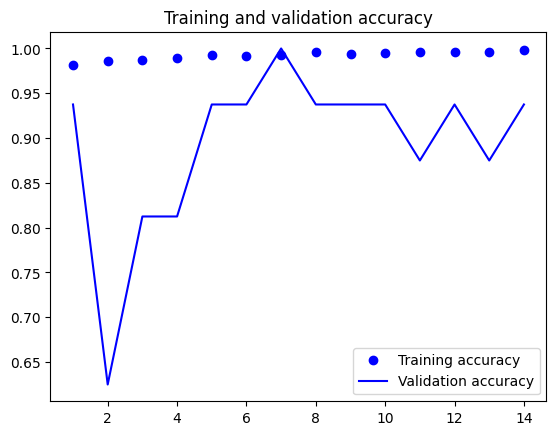

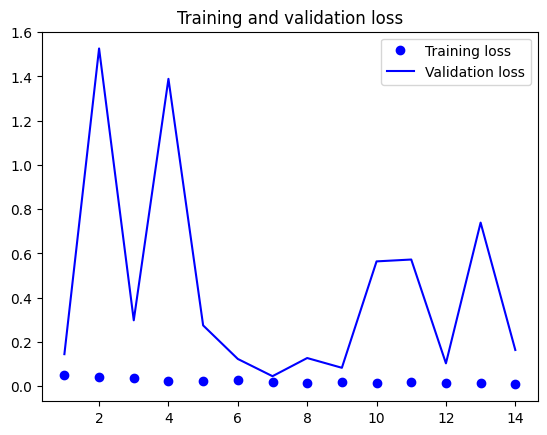

In [ ]:
#훈련 정확도와 손실 그래프 그리기
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("convnet_from_scratch_1256.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

20/20 [==============================] - 71s 2s/step - loss: 1.0831 - accuracy: 0.7965
테스트 정확도: 0.796


- 3차: 모델 크기 키우기(params 기존: 991,041 -> 변경: 2,726,977)


In [ ]:
#모델선언
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding = "same")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     73856     
                                                           

In [40]:
#모델 훈련 설정하기
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#모델훈련
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_1609.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.TensorBoard(
        log_dir = "full_path_to_your_log_dir_1609",
        histogram_freq = 1,
        write_graph = True, write_images = True)
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 58s 319ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 1.1498 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 61s 363ms/step - loss: 0.0142 - accuracy: 0.9964 - val_loss: 1.1459 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 54s 317ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 1.1480 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 59s 350ms/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 1.8972 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 52s 311ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 1.9907 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 57s 337ms/step - loss: 0.0193 - accuracy: 0.9962 - val_loss: 1.5035 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 51s 305ms/step - loss: 0.0192 - accuracy: 0.9948 - val_loss: 3.0560 - val_ac

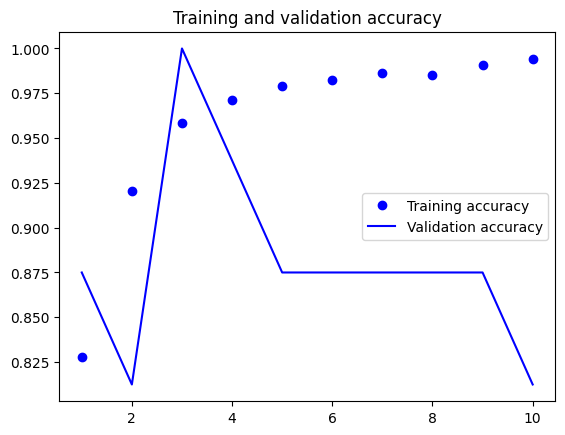

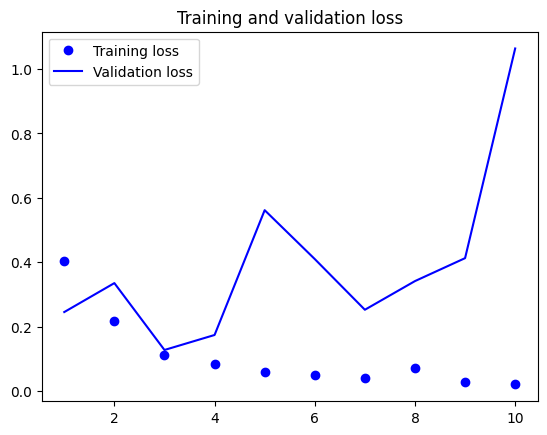

In [ ]:
#훈련 정확도와 손실 그래프 그리기
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#테스트 세트에서 모델 평가하기
test_model = keras.models.load_model("convnet_from_scratch_1609.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

20/20 [==============================] - 4s 134ms/step - loss: 1.0925 - accuracy: 0.7548
테스트 정확도: 0.755


#문제2. 이미지분류학습 결과 텐서보드 시각화

In [45]:
#텐서보드 확인
#!pip install -U tensorboard
#%load_ext tensorboard
#%reload_ext tensorboard
!pip install tensorboard --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
logdir = "full_path_to_your_log_dir_1609"
%tensorboard --logdir=logdir
%tensorboard dev upload --logdir {log_dir} runs

In [59]:
#port error날때 사용
#!lsof -i:6006
!kill PID "28898"

/bin/bash: line 0: kill: PID: arguments must be process or job IDs
